# BraTS 
In this Notebook we demonstrate how to utilize the BraTS package to use top performing algorithms from recent BraTS challenges.

---
## Getting Started

#### This tutorial requires:

   - Python 3.8+
   - Docker: Installation instructions on the official [website](https://docs.docker.com/get-docker/)


#### Optional but recommended:
   <!--CUDA 11.4+ (https://developer.nvidia.com/cuda-toolkit)-->
   - GPU with CUDA support (*otherwise CPU can be used for a some algorithms*) 
   - NVIDIA Container Toolkit: Refer to the [NVIDIA install guide](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html) and the official [GitHub page](https://github.com/NVIDIA/nvidia-container-toolkit) 


In [ ]:
# Installations
!pip install brats matplotlib ipywidgets > /dev/null

%load_ext autoreload
%autoreload 2

BASE_PATH = "./"

## Imports

In [ ]:
from pathlib import Path

import utils  # local file
from brats import AdultGliomaPreTreatmentSegmenter
from brats.constants import AdultGliomaPreTreatmentAlgorithms

---

## Data

### Example data
`brats` expects *preprocessed* input data as NIfTI files (*preprocessed* meaning the files should be co-registerend, skullstripped and in SRI-24 space).

In this example we provide:
- two set of preprocessed inputs for segmentation in `BraTS/data/segmentation` (data from [RSNA-ASNR-MICCAI BraTS Continuous Evaluation Challenge](https://www.synapse.org/Synapse:syn51156910/wiki/622351))
- one set of inputs for inpainting in `BraTS/data/inpainting` (data from [ASNR-MICCAI BraTS Local Synthesis of Tissue via Inpainting](https://www.synapse.org/Synapse:syn51156910/wiki/622357))

To get an intuition of the data, one example slice of the 3D scans is visualized below for a set of segementation (t1n, t1c, t2f, t2w) and inpainting (t1n, mask) inputs.
We do not separately plot data for the Missing MRI algorithms since they are equivalent to segmentation data (except that on modality can be missing)

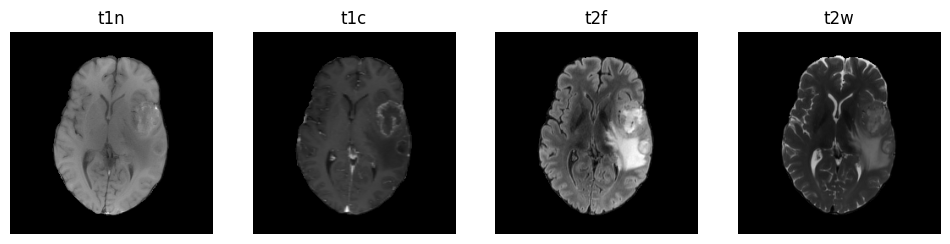

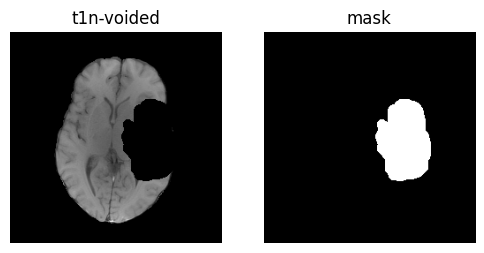

In [ ]:
subject = "BraTS-GLI-00001-000"
segmentation_data_path = Path(BASE_PATH) / "data" / "segmentation"
inpainting_data_path = Path(BASE_PATH) / "data" / "inpainting"
missing_mri_path = segmentation_data_path

segmentation_subject_path = segmentation_data_path / subject
inpainting_subject_path = inpainting_data_path / subject

utils.visualize_segmentation_data(segmentation_data_path, subject_id=subject)
utils.visualize_inpainting_data(inpainting_data_path, subject_id=subject)

### Using your data
If your data is *not* preprocessed yet, consider using our [BrainLes preprocessing](https://github.com/BrainLesion/preprocessing) package (or its predecessor [BraTS-Toolkit](https://github.com/neuronflow/BraTS-Toolkit)).

## Using BraTS

### Segmentation Tasks

#### Minimal example using default settings

In [6]:
segmenter = AdultGliomaPreTreatmentSegmenter()
segmenter.infer_single(
    t1c=segmentation_subject_path / f"{subject}-t1c.nii.gz",
    t1n=segmentation_subject_path / f"{subject}-t1n.nii.gz",
    t2f=segmentation_subject_path / f"{subject}-t2f.nii.gz",
    t2w=segmentation_subject_path / f"{subject}-t2w.nii.gz",
    output_file="segmentation.nii.gz",
)

2025-03-06 13:17:17.847 | INFO     | brats.core.brats_algorithm:__init__:48 - Instantiated AdultGliomaPreTreatmentSegmenter with algorithm: BraTS23_1 by André Ferreira, et al.
2025-03-06 13:17:17.848 | INFO     | brats.core.brats_algorithm:_infer_single:155 - Performing single inference


──────────────────────────────────────────────── Citation Reminder ────────────────────────────────────────────────

Please support our development by citing the relevant manuscripts for the used algorithm:

                                              BraTS Package | N/A                                         
------------------------------------------------------------+---------------------------------------------
 Challenge (Adult Glioma Segmentation (Pre Treatment) 2023) | https://arxiv.org/abs/2107.02314            
------------------------------------------------------------+---------------------------------------------
                         Algorithm (André Ferreira, et al.) | https://doi.org/10.1007/978-3-031-76163-8_8 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2025-03-06 13:17:17.892 | INFO     | brats.core.docker:_log_algorithm_info:329 - Running algorithm:  BraTS 2023 Adult Glioma Segmentation (Pre Treatment) [1st place]
2025-03-06 13:17:18.343 | INFO     | brats.core.docker:run_container:381 - Starting inference


Output()

2025-03-06 13:20:15.719 | INFO     | brats.core.docker:run_container:404 - Finished inference in 177.38 seconds
2025-03-06 13:20:15.720 | INFO     | brats.core.brats_algorithm:_infer_single:179 - Saved output to: /home/marcelrosier/tutorials/BraTS/segmentation.nii.gz


### Visualize results


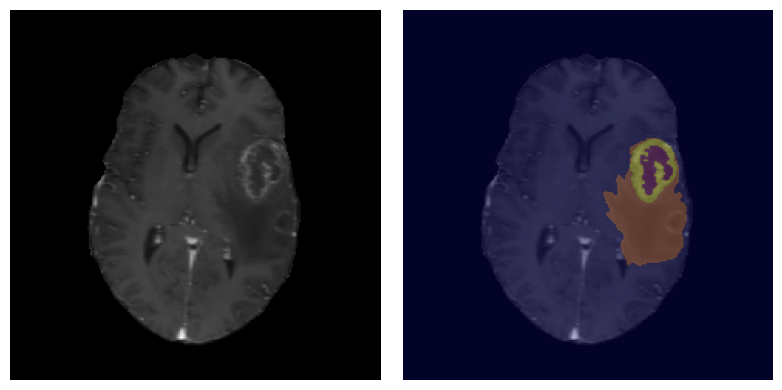

In [7]:
utils.visualize_segmentation(
    modality_file=segmentation_subject_path / f"{subject}-t1c.nii.gz",
    segmentation_file="segmentation.nii.gz",
)

#### Batch processing

BraTS allows to run an algorithm for a single set of input images (t1n, t1c, t2f, t2w of the same patient) or for multiple subjects.
Each of the available classes provides methods for both: 
- `.infer_single(...)` that takes in the paths to the required input modalities and a path to store the result
- `.infer_batch(...)` that takes in a path to a data folder containing multiple sets of subjects and a path to an output folder to store the results

The sets of subject inputs need to be stored in a specific structure to be recognized by the package:
```
data_folder
┣ A
┃ ┣ A-t1c.nii.gz
┃ ┣ A-t1n.nii.gz
┃ ┣ A-t2f.nii.gz
┃ ┗ A-t2w.nii.gz
┣ B
┃ ┣ B-t1c.nii.gz
┃ ┣ ...
```

In [8]:
output_path = Path("batch_out")

segmenter = AdultGliomaPreTreatmentSegmenter()
segmenter.infer_batch(
    data_folder=segmentation_data_path,
    output_folder=output_path,
)

print(f"Inferred segmentations: {[path.name for path in output_path.iterdir()]}")

2025-03-06 13:23:06.497 | INFO     | brats.core.brats_algorithm:__init__:48 - Instantiated AdultGliomaPreTreatmentSegmenter with algorithm: BraTS23_1 by André Ferreira, et al.
2025-03-06 13:23:06.499 | INFO     | brats.core.brats_algorithm:_infer_batch:198 - Found 2 subjects: BraTS-GLI-00001-000, BraTS-GLI-00001-001 


2025-03-06 13:23:06.551 | INFO     | brats.core.brats_algorithm:_infer_batch:207 - Standardized input names to match algorithm requirements.


──────────────────────────────────────────────── Citation Reminder ────────────────────────────────────────────────

Please support our development by citing the relevant manuscripts for the used algorithm:

                                              BraTS Package | N/A                                         
------------------------------------------------------------+---------------------------------------------
 Challenge (Adult Glioma Segmentation (Pre Treatment) 2023) | https://arxiv.org/abs/2107.02314            
------------------------------------------------------------+---------------------------------------------
                         Algorithm (André Ferreira, et al.) | https://doi.org/10.1007/978-3-031-76163-8_8 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2025-03-06 13:23:06.556 | INFO     | brats.core.docker:_log_algorithm_info:329 - Running algorithm:  BraTS 2023 Adult Glioma Segmentation (Pre Treatment) [1st place]
2025-03-06 13:23:07.049 | INFO     | brats.core.docker:run_container:381 - Starting inference


Output()

2025-03-06 13:26:34.594 | INFO     | brats.core.docker:run_container:404 - Finished inference in 207.54 seconds
2025-03-06 13:26:34.595 | INFO     | brats.core.brats_algorithm:_infer_batch:225 - Saved outputs to: /home/marcelrosier/tutorials/BraTS/batch_out


Inferred segmentations: ['BraTS-GLI-00001-000.nii.gz', 'BraTS-GLI-00001-001.nii.gz']


## Advanced Usage

By default the algorithm that won the most recent challenge will be run on the first available GPU. This behavior and other options can be adapted, e.g.:
- Select a different algorithm from the available constants (Enum classes for each challenge) with the `algorithm` parameter
- Select a specific GPU if multiple are available with the `cuda_decives` parameter
- Force CPU execution with the `force_cpu`flag (will cause an exception for many algorithms since many do not support CPU execution, check our [overview tables](https://github.com/BrainLesion/BraTS?tab=readme-ov-file#available-algorithms-and-usage) to find CPU capable algorithms)
- Save the generated logs in a log file with the `log_file` parameter

In [9]:
segmenter = AdultGliomaPreTreatmentSegmenter(
    algorithm=AdultGliomaPreTreatmentAlgorithms.BraTS23_3,  # Use the 3rd placed algorithm of the Adult Glioma BraTS 2023 challenge
    cuda_devices="1",  # Select GPU device with ID 4
    force_cpu=False,  # default, could be set to True to force CPU
)

segmenter.infer_single(
    t1c=segmentation_subject_path / f"{subject}-t1c.nii.gz",
    t1n=segmentation_subject_path / f"{subject}-t1n.nii.gz",
    t2f=segmentation_subject_path / f"{subject}-t2f.nii.gz",
    t2w=segmentation_subject_path / f"{subject}-t2w.nii.gz",
    output_file="segmentation.nii.gz",
    log_file="segmentation.log",  # Save the logs in a new filed called `segmentation.log`
)

2025-03-06 13:31:01.989 | INFO     | brats.core.brats_algorithm:__init__:48 - Instantiated AdultGliomaPreTreatmentSegmenter with algorithm: BraTS23_3 by Fadillah Adamsyah Maani, et al.
2025-03-06 13:31:01.999 | INFO     | brats.utils.data_handling:add_log_file_handler:41 - Logging console logs and further debug information to: /home/marcelrosier/tutorials/BraTS/segmentation.log
2025-03-06 13:31:02.001 | INFO     | brats.core.brats_algorithm:_infer_single:155 - Performing single inference


──────────────────────────────────────────────── Citation Reminder ────────────────────────────────────────────────

Please support our development by citing the relevant manuscripts for the used algorithm:

                                              BraTS Package | N/A                                          
------------------------------------------------------------+----------------------------------------------
 Challenge (Adult Glioma Segmentation (Pre Treatment) 2023) | https://arxiv.org/abs/2107.02314             
------------------------------------------------------------+----------------------------------------------
                Algorithm (Fadillah Adamsyah Maani, et al.) | https://doi.org/10.1007/978-3-031-76163-8_24 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2025-03-06 13:31:02.036 | INFO     | brats.core.docker:_log_algorithm_info:329 - Running algorithm:  BraTS 2023 Adult Glioma Segmentation (Pre Treatment) [3rd place]
2025-03-06 13:31:02.273 | INFO     | brats.utils.zenodo:check_additional_files_path:60 - Found downloaded local additional_files: 11573315_v1.0.1
2025-03-06 13:31:02.275 | INFO     | brats.utils.zenodo:check_additional_files_path:72 - Latest additional files (11573315_v1.0.1) are already present.
2025-03-06 13:31:02.665 | INFO     | brats.core.docker:run_container:381 - Starting inference


Output()

2025-03-06 13:33:55.200 | INFO     | brats.core.docker:run_container:404 - Finished inference in 172.53 seconds
2025-03-06 13:33:55.201 | INFO     | brats.core.brats_algorithm:_infer_single:179 - Saved output to: /home/marcelrosier/tutorials/BraTS/segmentation.nii.gz


## Algorithms from other Challenges

BraTS provides the algorithms from all available recent BraTS Challenges, i.e.:
- Adult Glioma Pre Treatment Segmentation 
- Adult Glioma Post Treatment Segmentation
- BraTS-Africa Segmentation
- Meningioma Segmentation
- Brain Metastases Segmentation
- Pediatric Tumors Segmentation

The package provides a separate class and algorithm constants for each of the challenges.<br>
The examples above were demonstrated using the class and constants of the Adult Glioma Pre Treatment Segmentation challenge.

In an identical way you can use:
- `MeningiomaSegmenter` class with `MeningiomaAlgorithms`
- `PediatricSegmenter` class with `PediatricAlgorithms`
- etc.

A full overview of all available algorithms can be found in the projects Readme [here](https://github.com/BrainLesion/BraTS/?tab=readme-ov-file#algorithms).

In [21]:
# e.g. for the Meningioma Algorithms
from brats import MeningiomaSegmenter
from brats.constants import MeningiomaAlgorithms

segmenter = MeningiomaSegmenter(
    algorithm=MeningiomaAlgorithms.BraTS23_2, cuda_devices="1"
)
segmenter.infer_batch(
    data_folder=segmentation_data_path, output_folder="men_output", log_file="test.log"
)

2025-03-06 13:47:14.189 | INFO     | brats.core.brats_algorithm:__init__:48 - Instantiated MeningiomaSegmenter with algorithm: BraTS23_2 by Ziyan Huang, et al.
2025-03-06 13:47:14.199 | INFO     | brats.utils.data_handling:add_log_file_handler:41 - Logging console logs and further debug information to: /home/marcelrosier/tutorials/BraTS/test.log
2025-03-06 13:47:14.201 | INFO     | brats.core.brats_algorithm:_infer_batch:198 - Found 2 subjects: BraTS-GLI-00001-000, BraTS-GLI-00001-001 
2025-03-06 13:47:14.257 | INFO     | brats.core.brats_algorithm:_infer_batch:207 - Standardized input names to match algorithm requirements.


──────────────────────────────────────────────── Citation Reminder ────────────────────────────────────────────────

Please support our development by citing the relevant manuscripts for the used algorithm:

                            BraTS Package | N/A                                          
------------------------------------------+----------------------------------------------
 Challenge (Meningioma Segmentation 2023) | https://arxiv.org/abs/2305.07642             
------------------------------------------+----------------------------------------------
          Algorithm (Ziyan Huang, et al.) | https://doi.org/10.1007/978-3-031-76163-8_13 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2025-03-06 13:47:14.262 | INFO     | brats.core.docker:_log_algorithm_info:329 - Running algorithm:  BraTS 2023 Meningioma Segmentation [2nd place]
2025-03-06 13:47:14.751 | INFO     | brats.core.docker:run_container:381 - Starting inference


Output()

2025-03-06 13:47:57.705 | INFO     | brats.core.docker:run_container:404 - Finished inference in 42.95 seconds
2025-03-06 13:47:57.748 | INFO     | brats.core.brats_algorithm:_infer_batch:225 - Saved outputs to: /home/marcelrosier/tutorials/BraTS/men_output


## Inpainting

The Inpainting algorithms have a mostly identical interface except for the obvious change of input files.  
Everything else remains the same.

In [26]:
from brats import Inpainter

inpainter = Inpainter()
inpainter.infer_single(
    t1n=inpainting_subject_path / f"{subject}-t1n-voided.nii.gz",
    mask=inpainting_subject_path / f"{subject}-mask.nii.gz",
    output_file="inpainting.nii.gz",
)

2025-03-06 14:15:15.783 | INFO     | brats.core.brats_algorithm:__init__:48 - Instantiated Inpainter with algorithm: BraTS23_1 by Juexin Zhang, et al.
2025-03-06 14:15:15.785 | INFO     | brats.core.brats_algorithm:_infer_single:155 - Performing single inference


──────────────────────────────────────────────── Citation Reminder ────────────────────────────────────────────────

Please support our development by citing the relevant manuscripts for the used algorithm:

                    BraTS Package | N/A                                          
----------------------------------+----------------------------------------------
      Challenge (Inpainting 2023) | https://arxiv.org/abs/2305.08992             
----------------------------------+----------------------------------------------
 Algorithm (Juexin Zhang, et al.) | https://doi.org/10.1007/978-3-031-76163-8_21 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2025-03-06 14:15:15.805 | INFO     | brats.core.docker:_log_algorithm_info:329 - Running algorithm:  BraTS 2023 Inpainting [1st place]
2025-03-06 14:15:16.054 | INFO     | brats.utils.zenodo:check_additional_files_path:60 - Found downloaded local additional_files: 13382922_v1.0.1
2025-03-06 14:15:16.054 | INFO     | brats.utils.zenodo:check_additional_files_path:72 - Latest additional files (13382922_v1.0.1) are already present.
2025-03-06 14:15:16.511 | INFO     | brats.core.docker:run_container:381 - Starting inference


Output()

2025-03-06 14:15:29.139 | INFO     | brats.core.docker:run_container:404 - Finished inference in 12.63 seconds
2025-03-06 14:15:29.140 | INFO     | brats.core.brats_algorithm:_infer_single:179 - Saved output to: /home/marcelrosier/tutorials/BraTS/inpainting.nii.gz


### Visualize Results

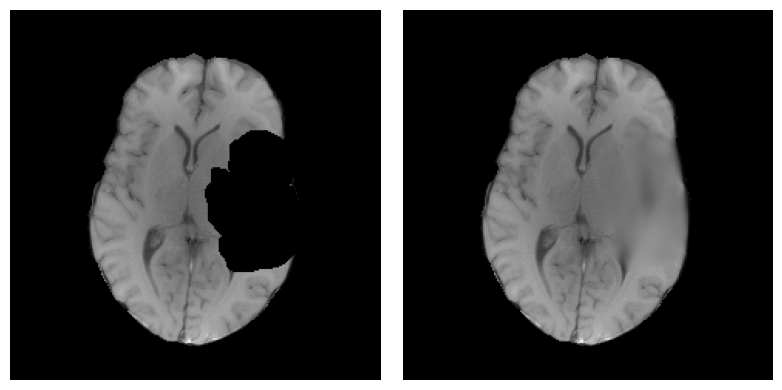

In [27]:
utils.visualize_inpainting(
    t1n_voided=inpainting_subject_path / f"{subject}-t1n-voided.nii.gz",
    prediction="inpainting.nii.gz",
)

### Batch inference
Batch inference can be used in the same way, but expects an adapted structure of the data folder:

```
data_folder
┣ A
┃ ┣ A-t1n-voided.nii.gz
┃ ┣ A-mask.nii.gz
┣ B
┃ ┣ B-t1n-voided.nii.gz
┃ ┣ ...
```

In [28]:
output_path = Path("inpainting_batch_out")

inpainter = Inpainter()
inpainter.infer_batch(
    data_folder=inpainting_data_path,
    output_folder=output_path,
)

print([path.name for path in output_path.iterdir()])

2025-03-06 14:15:34.599 | INFO     | brats.core.brats_algorithm:__init__:48 - Instantiated Inpainter with algorithm: BraTS23_1 by Juexin Zhang, et al.
2025-03-06 14:15:34.600 | INFO     | brats.core.brats_algorithm:_infer_batch:198 - Found 1 subjects: BraTS-GLI-00001-000 
2025-03-06 14:15:34.610 | INFO     | brats.core.brats_algorithm:_infer_batch:207 - Standardized input names to match algorithm requirements.


──────────────────────────────────────────────── Citation Reminder ────────────────────────────────────────────────

Please support our development by citing the relevant manuscripts for the used algorithm:

                    BraTS Package | N/A                                          
----------------------------------+----------------------------------------------
      Challenge (Inpainting 2023) | https://arxiv.org/abs/2305.08992             
----------------------------------+----------------------------------------------
 Algorithm (Juexin Zhang, et al.) | https://doi.org/10.1007/978-3-031-76163-8_21 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2025-03-06 14:15:34.617 | INFO     | brats.core.docker:_log_algorithm_info:329 - Running algorithm:  BraTS 2023 Inpainting [1st place]
2025-03-06 14:15:34.925 | INFO     | brats.utils.zenodo:check_additional_files_path:60 - Found downloaded local additional_files: 13382922_v1.0.1
2025-03-06 14:15:34.926 | INFO     | brats.utils.zenodo:check_additional_files_path:72 - Latest additional files (13382922_v1.0.1) are already present.
2025-03-06 14:15:35.557 | INFO     | brats.core.docker:run_container:381 - Starting inference


Output()

2025-03-06 14:15:48.308 | INFO     | brats.core.docker:run_container:404 - Finished inference in 12.75 seconds
2025-03-06 14:15:48.309 | INFO     | brats.core.brats_algorithm:_infer_batch:225 - Saved outputs to: /home/marcelrosier/tutorials/BraTS/inpainting_batch_out


['BraTS-GLI-00001-000.nii.gz']


## Missing MRI Synthesis (BraSyn)

MissingMRI algorithms allow to synthesize a missing modality image from the three others (any combination is possible).  
Below we demonstrate how to generate a `t2w` image from `t1c`, `t1n` and `t2f`.

In [ ]:
from brats import MissingMRI
from brats.constants import MissingMRIAlgorithms

missing_mri = MissingMRI()
missing_mri.infer_single(
    t1c=segmentation_subject_path / f"{subject}-t1c.nii.gz",
    t1n=segmentation_subject_path / f"{subject}-t1n.nii.gz",
    t2f=segmentation_subject_path / f"{subject}-t2f.nii.gz",
    output_file="synthesized_t2w.nii.gz",
)
# .infer_batch() works identical to the segmentation/ inpainting batch infer methods

2025-03-06 13:39:02.261 | INFO     | brats.core.brats_algorithm:__init__:48 - Instantiated MissingMRI with algorithm: BraTS24_1 by Jihoon Cho, Seunghyuck Park, Jinah Park
2025-03-06 13:39:02.263 | INFO     | brats.core.brats_algorithm:_infer_single:155 - Performing single inference


──────────────────────────────────────────────── Citation Reminder ────────────────────────────────────────────────

Please support our development by citing the relevant manuscripts for the used algorithm:

                                           BraTS Package | N/A                              
---------------------------------------------------------+----------------------------------
 Challenge (BraTS MRI Synthesis Challenge (BraSyn) 2024) | https://arxiv.org/abs/2305.09011 
---------------------------------------------------------+----------------------------------
     Algorithm (Jihoon Cho, Seunghyuck Park, Jinah Park) | N/A                              

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2025-03-06 13:39:02.287 | INFO     | brats.core.docker:_log_algorithm_info:329 - Running algorithm:  BraTS 2024 BraTS MRI Synthesis Challenge (BraSyn) [1st place]
2025-03-06 13:39:02.964 | INFO     | brats.utils.zenodo:check_additional_files_path:60 - Found downloaded local additional_files: 14287969_v1.0.0
2025-03-06 13:39:02.965 | INFO     | brats.utils.zenodo:check_additional_files_path:72 - Latest additional files (14287969_v1.0.0) are already present.
2025-03-06 13:39:03.861 | INFO     | brats.core.docker:run_container:381 - Starting inference


Output()

2025-03-06 13:39:41.185 | INFO     | brats.core.docker:run_container:404 - Finished inference in 37.32 seconds
2025-03-06 13:39:41.187 | INFO     | brats.core.brats_algorithm:_infer_single:179 - Saved output to: /home/marcelrosier/tutorials/BraTS/synthesized_t2w.nii.gz


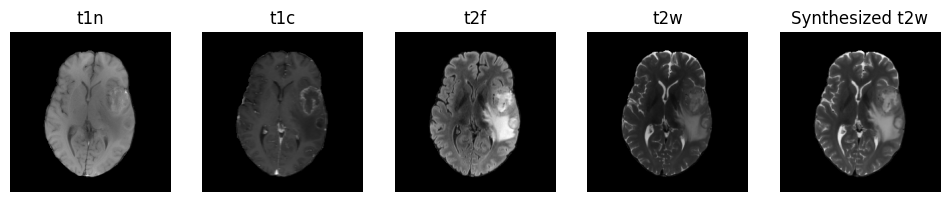

In [20]:
utils.visualize_missing_mri_t2w(synthesized_t2w="synthesized_t2w.nii.gz", data_folder=missing_mri_path)